In [81]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tensorflow as tf

Task: Load the data 

In [82]:
IMG_SIZE = (128, 128)
BATCH_SIZE = 32

dataset = tf.keras.utils.image_dataset_from_directory(
    "/Users/ADMIN/desktop/cat vs dog/animals",
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode="binary",  # cat = 0, dog = 1
    shuffle=True
)
print(dataset.class_names)


Found 1000 files belonging to 2 classes.
['cat', 'dog']


Task: Data Visualization

(32, 128, 128, 3)
tf.Tensor(
[[0.]
 [1.]
 [1.]
 [1.]
 [0.]
 [1.]
 [0.]
 [1.]
 [0.]
 [0.]], shape=(10, 1), dtype=float32)


2025-12-16 15:07:20.315519: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


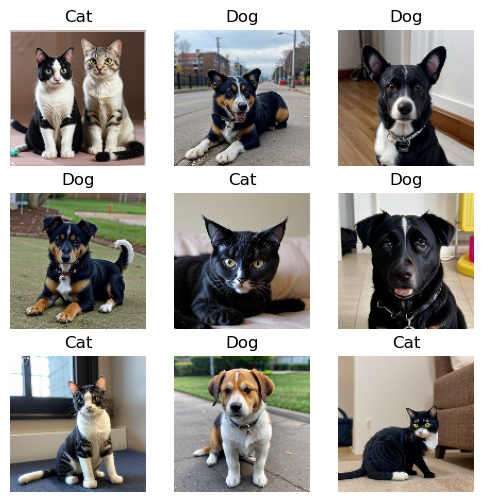

In [83]:
import matplotlib.pyplot as plt

for images, labels in dataset.take(1):
    print(images.shape)   # (batch_size, height, width, channels)
    print(labels[:10])

plt.figure(figsize=(6,6))
for i in range(9):
    plt.subplot(3,3,i+1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title("Cat" if labels[i] == 0 else "Dog")
    plt.axis("off")
plt.show()

Task: Splitting and pre-processing the data before training the model

In [84]:
dataset_size = dataset.cardinality().numpy()
print("Total batches:", dataset_size)

dataset = dataset.shuffle(1000, seed=42)

train_size = int(0.7 * dataset_size)
val_size   = int(0.15 * dataset_size)

train_ds = dataset.take(train_size)
val_ds   = dataset.skip(train_size).take(val_size)
test_ds  = dataset.skip(train_size + val_size)
print("Train batches:", train_ds.cardinality().numpy())
print("Val batches:", val_ds.cardinality().numpy())
print("Test batches:", test_ds.cardinality().numpy())

Total batches: 32
Train batches: 22
Val batches: 4
Test batches: 6


In [85]:
normalization_layer = tf.keras.layers.Rescaling(1./255)

train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
val_ds   = val_ds.map(lambda x, y: (normalization_layer(x), y))
test_ds  = test_ds.map(lambda x, y: (normalization_layer(x), y))

In [86]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.1),
    tf.keras.layers.RandomZoom(0.1),
])

Task: Train the model

In [87]:
from tensorflow.keras.models import Sequential # type: ignore
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense # type: ignore

model = Sequential([
    data_augmentation,
    Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)), MaxPooling2D((2, 2)),

    Conv2D(64, (3, 3), activation='relu'),MaxPooling2D((2, 2)),

    Flatten(),
    Dense(64, activation='relu'),
    Dense(1, activation='sigmoid') 
])

In [88]:
model.compile(
    optimizer="adam",
    loss="binary_crossentropy",
    metrics=["accuracy"]
)
model.fit(train_ds, validation_data=val_ds,epochs=20)
test_loss, test_acc = model.evaluate(test_ds)
print("Test accuracy:", test_acc)


Epoch 1/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 4s 120ms/step - accuracy: 0.5784 - loss: 0.8380 - val_accuracy: 0.6797 - val_loss: 0.6363
Epoch 2/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 3s 112ms/step - accuracy: 0.7210 - loss: 0.5852 - val_accuracy: 0.6406 - val_loss: 0.6597
Epoch 3/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 3s 114ms/step - accuracy: 0.7238 - loss: 0.5129 - val_accuracy: 0.8516 - val_loss: 0.3231
Epoch 4/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 3s 112ms/step - accuracy: 0.8569 - loss: 0.3651 - val_accuracy: 0.8516 - val_loss: 0.3285
Epoch 5/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 3s 115ms/step - accuracy: 0.8597 - loss: 0.3360 - val_accuracy: 0.9219 - val_loss: 0.2446
Epoch 6/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 3s 113ms/step - accuracy: 0.8700 - loss: 0.2760 - val_accuracy: 0.9135 - val_loss: 0.2552
Epoch 7/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 3s 114ms/step - accuracy: 0.9409 - loss: 0.1785 - val_accuracy: 0.9062 - val_loss: 0.2392
Epoch 8/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 3s 113ms/step - accuracy: 0.9329 - loss: 0.1659 - val_accuracy: 0.

In [89]:

model.save("cat_dog_model.keras")